In [1]:
#Preliminary analysis code for S4 2021 group project
#LPS 7-29-21: Initial draft
#LPS 7-30-21: Update selection criteria, save random sample
#LPS 8-2-21: Add functions to get publication space, keyword, calculate specter distance
#LPS 8-2-21: Calculate specter distance between min and max years for authors in sample
#LPS 8-3-21: Normalize specter distance across career by career length
#LPS 8-4-21: Calculate specter distance between first and second decade of career
#LPS 8-4-21: Plot some examples of fractional change in keyword type across career
#LPS 8-4-21: Calculate specter distance by year for all researchers
#LPS 8-4-21: Identify keywords with greatest prevalence by pid/level/decade

In [2]:
%matplotlib inline 

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from seaborn import lineplot,color_palette,scatterplot
from scipy.spatial import distance
from scipy.stats import pearsonr,ttest_rel

In [4]:
load_from_s4_drive = False

if load_from_s4_drive:
    a = pd.read_csv('~/datasets/s4/MENTORSHIP/authorship.csv')
    m = pd.read_csv('~/datasets/s4/MENTORSHIP/mentorship_with_pqinfo.csv')
    r = pd.read_csv('~/datasets/s4/MENTORSHIP/researcher.csv')
else: #use local copies of files
    a = pd.read_csv('authorship.csv')
    m = pd.read_csv('mentorship_with_pqinfo.csv')
    r = pd.read_csv('researcher.csv')
    
specter = pd.read_hdf('specter_data_v1.h5', 'specter')
authors = pd.read_hdf('pub_data_v1.h5', 'authors')
pubs = pd.read_hdf('pub_data_v1.h5', 'pubs')
pub_kws = pd.read_hdf('pub_data_v1.h5', 'pub_kws')
kws = pd.read_hdf('pub_data_v1.h5', 'kws')
specter_dists = pd.read_csv('specter_dists.csv')
pub_career_lengths = pd.read_csv('pub_career_lengths.csv')
specter_dists_career_lengths = pd.read_csv('specter_dists_career_lengths.csv')

In [5]:
#calculate the year that mentors ended training (if available)
mentor_stop_year = m.groupby(['MenteeID'])['StopYear'].max()
mentor_stop_year.name = 'MentorStopYear'
m = pd.merge(m, mentor_stop_year, how='left', left_on='MentorID', right_on='MenteeID', copy=True)

#screen for errors in mentor training stop date, replace with nans
#missing training date for mentor
m.loc[m['MentorStopYear']== 0, ['MentorStopYear']] = np.nan
#mentor ends training after trainee begins
m.loc[m['MentorStopYear']>=m['StopYear'], ['MentorStopYear']] = np.nan
#more than 60 years between end of mentor training and trainee graduation
m.loc[(m['StopYear']-m['MentorStopYear']) > 60, ['MentorStopYear']] = np.nan

In [6]:
#get mentor's primary research area
m = pd.merge(m, r[['PID','ResearchArea']], left_on='MentorID', right_on='PID')
m['ResearchArea'] = m['ResearchArea'].str.split(pat=',').map(lambda x:x[0])

In [7]:
#calculate the year that the mentor acquired their first student (often unavailable)
first_trainee_year = m.loc[m['StartYear']>0].groupby(['MentorID'])['StartYear'].min()
first_trainee_year.name = 'FirstTraineeYear'
m = pd.merge(m, first_trainee_year, how='left', on='MentorID', copy=True)

In [8]:
#check if students have trained others
n_mentees = m.groupby('MentorID')['MenteeID'].count()
n_mentees.name = 'NMentees'
m = pd.merge(m, n_mentees, left_on='MenteeID', right_on='MentorID', how='left')
m['NMentees'] = m['NMentees'].fillna(0)
m['Continued'] = m['NMentees'] > 0

In [9]:
m.loc[m['PQadded']==1, 'MentorshipType'].value_counts() #confirm that it's all grad students from ProQuest (code:1)

1    396335
Name: MentorshipType, dtype: int64

In [11]:
#screen for people with > 1 paper in dataset
paper_count = a.groupby('PID')['MAGPaperID'].count()
has_papers = paper_count[(paper_count>1) == True].index.values

In [12]:
#check size of the dataset with various selection criteria

r1 = m.shape[0]
m1 = m['MentorID'].drop_duplicates().shape[0]
t1 = m['MenteeID'].drop_duplicates().shape[0]

s = m.loc[(m['PQadded']==1)]
r2 = s.shape[0]
m2 = s['MentorID'].drop_duplicates().shape[0]
t2 = s['MenteeID'].drop_duplicates().shape[0]

s = m.loc[(m['PQadded']==1) &\
          (~m['MentorStopYear'].isna())]
r3 = s.shape[0]
m3 = s['MentorID'].drop_duplicates().shape[0]
t3 = s['MenteeID'].drop_duplicates().shape[0]

s = m.loc[(m['PQadded']==1) &\
          (~m['MentorStopYear'].isna())&\
          (m['MenteeID'].isin(has_papers))&\
          (m['MentorID'].isin(has_papers))]
r4 = s.shape[0]
m4 = s['MentorID'].drop_duplicates().shape[0]
t4 = s['MenteeID'].drop_duplicates().shape[0]

print("Total training relationships in AFT: {} ({} mentors, {} trainees)".\
      format(r1,m1,t1))
print("Subset from ProQuest: {} ({:.0f}% of AFT data) ({} mentors, {} students)".\
      format(r2, (r2/r1)*100, m2, t2))
print("Subset with mentor career start dates: {} ({:.0f}% of ProQuest subset) ({} mentors, {} students)".\
      format(r3, (r3/r2)*100, m3, t3))
print("Subset with more than one paper: {} ({:.0f}% of start date subset) ({} mentors, {} students)".\
      format(r4, (r4/r3)*100, m4, t4))

Total training relationships in AFT: 711005 (178835 mentors, 627008 trainees)
Subset from ProQuest: 396335 (56% of AFT data) (108947 mentors, 395967 students)
Subset with mentor career start dates: 78257 (20% of ProQuest subset) (17481 mentors, 78036 students)
Subset with more than one paper: 54523 (70% of start date subset) (14340 mentors, 54331 students)


In [13]:
#save list of pids to analyze

m_subset = m.loc[(m['PQadded']==1) &               #ProQuest data
                 (~m['MentorStopYear'].isna())&    #known mentor career start date
                 (m['MenteeID'].isin(has_papers))& #student has > 1 paper in dataset
                 (m['MentorID'].isin(has_papers))] #mentor has > 1 paper in dataset

m_sample = m_subset.sample(n=1000, random_state=0) #take random sample of mentor-student pairs
pids_sample = m_sample['MenteeID'].append(m_sample['MentorID']).drop_duplicates().rename('pid') #get unique pids

#pids_sample.to_csv('pids_sample.csv')

In [14]:
#are there mentors with more than one trainee in the sample - yes
m_sample.groupby('MentorID')['MenteeID'].count().value_counts()

1    903
2     45
4      1
3      1
Name: MenteeID, dtype: int64

In [15]:
#are there mentees that are duplicated (as mentors) in the sample - yes
m_sample['MenteeID'].isin(m_sample['MentorID']).sum()

1

In [16]:
def author_pub_space(pid, pubs_df=pubs, authors_df=authors, specter_df=specter):
    """
    Return a publication space (publication IDs, date published, SPECTER vectors) for an author.
    pid: author identifier
    pubs_df, authors_df, specter_df: variables that contain data on publication/authorship/specter
    """
    ps = authors.loc[authors['PID']==pid].merge(pubs[['MAGPaperID','Year']],how='left').merge(specter,how='left')
    return ps

def pub_space_distance(pid1, pid2, y1=None, y2=None):
    """
    Returns SPECTER cosine distance between two groups of publications.
    To get distance between the same author at different times, set pid1 = pid2 and y1 != y2.
    pid1, pid2: author identifiers
    y1, y2: year ranges to filter by (in form [start_year, stop_year]), range is inclusive of
            publications in start year but not stop year
    """
    
    ps1 = author_pub_space(pid1)
    ps2 = author_pub_space(pid2)
    
    #filter by year range (if provided)
    if y1 is not None:
        ps1 = ps1.loc[(ps1['Year']>=y1[0]) & (ps1['Year']<y2[1])]
    if y2 is not None:
        ps2 = ps2.loc[(ps2['Year']>=y1[0]) & (ps2['Year']<y2[1])]
    
    c = [c for c in ps.columns if c.startswith('c')]
    
    return distance.cdist(ps1[c], ps2[c], 'cosine').mean()

def author_kw_space(pid, pubs_df=pubs, authors_df=authors, specter_df=specter):
    """
    Return a publication keyword space (publication IDs, date published, keyword data) for an author.
    pid: author identifier
    pubs_df, authors_df, specter_df: variables that contain data on publication/authorship/specter
    """
    ps = authors.loc[authors['PID']==pid].merge(pubs[['MAGPaperID','Year']],how='left')
    ks = ps.merge(pub_kws, how='left').merge(kws, how='left')
    return ks

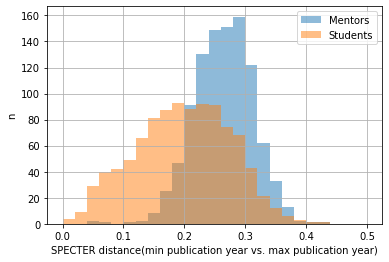

In [49]:
#calculate SPECTER distance between publications in minimum and maximum year
# d = []
# for i,pid in enumerate(pids_sample):
#     ps = author_pub_space(pid)
#     ymin = int(ps['Year'].min())
#     ymax = int(ps['Year'].max())
#     dist = pub_space_distance(pid, pid, y1=[ymin,ymin+1], y2=[ymax,ymax+1])
#     d.append((pid,dist))
#     print(f'\r{pid} ({i+1}/{len(pids_sample)})',end='')
# d = pd.DataFrame().from_records(d,columns=['PID','MinMaxYearSpecter'])
# d.to_csv('specter_dists.csv', index=False)

d = pd.read_csv('specter_dists.csv')
d = d.loc[:,['PID','MinMaxYearSpecter']]

#add the new data as a column in m_sample
d.columns=['MentorID','MentorMinMaxYearSpecter']
m_sample = pd.merge(m_sample, d, how='left')
d.columns=['MenteeID','MenteeMinMaxYearSpecter']
m_sample = pd.merge(m_sample, d, how='left')

#plot the distribution
m_sample['MentorMinMaxYearSpecter'].hist(alpha=0.5, label='Mentors', range=[0,0.5], bins=25)
m_sample['MenteeMinMaxYearSpecter'].hist(alpha=0.5, label='Students', range=[0,0.5], bins=25)
plt.xlabel('SPECTER distance(min publication year vs. max publication year)')
plt.ylabel('n')
plt.legend();

<AxesSubplot:xlabel='MentorMinMaxYearSpecter', ylabel='MenteeMinMaxYearSpecter'>

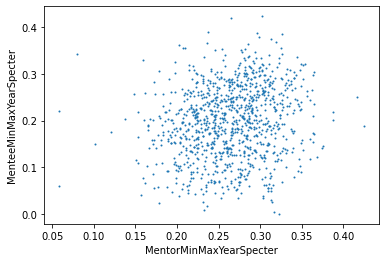

In [50]:
m_sample.plot.scatter(x='MentorMinMaxYearSpecter',y='MenteeMinMaxYearSpecter',s=1)

In [51]:
pearsonr(m_sample['MentorMinMaxYearSpecter'],m_sample['MenteeMinMaxYearSpecter'])

(0.16737799508259193, 1.015448227610229e-07)

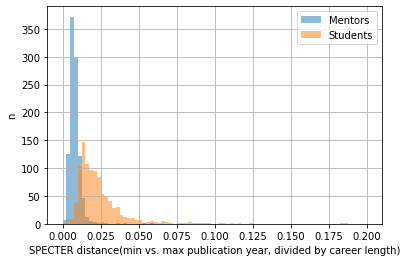

In [52]:
#calculate publication career lengths
# d = []
# for i,pid in enumerate(pids_sample):
#     ps = author_pub_space(pid)
#     ymin = int(ps['Year'].min())
#     ymax = int(ps['Year'].max())
#     d.append((pid,ymin,ymax))
#     print(f'\r{pid} ({i+1}/{len(pids_sample)})',end='')
# d = pd.DataFrame().from_records(d,columns=['PID','MinPubYear','MaxPubYears'])
# d['NPubYears'] = (d['MaxPubYear']+1) - d['MinPubYear']
# d.to_csv('pub_career_lengths.csv', index=False)

d1 = pd.read_csv('pub_career_lengths.csv')
m_sample = pd.merge(m_sample, d1.iloc[:,[0,3]].rename({'PID':'MentorID','NPubYears':'MentorNPubYears'},axis=1))
m_sample = pd.merge(m_sample, d1.iloc[:,[0,3]].rename({'PID':'MenteeID','NPubYears':'MenteeNPubYears'},axis=1))

d2 = m_sample.loc[:,['MenteeID','MentorID','MentorMinMaxYearSpecter','MenteeMinMaxYearSpecter','MentorNPubYears','MenteeNPubYears']]
d2['MentorNormDist'] = d2['MentorMinMaxYearSpecter']/d2['MentorNPubYears']
d2['MenteeNormDist'] = d2['MenteeMinMaxYearSpecter']/d2['MenteeNPubYears']
d2['MentorNormDist'].hist(alpha=0.5, label='Mentors', range=[0,0.2], bins=80)
d2['MenteeNormDist'].hist(alpha=0.5, label='Students', range=[0,0.2], bins=80)
plt.xlabel('SPECTER distance(min vs. max publication year, divided by career length)')
plt.ylabel('n')
plt.legend();

<AxesSubplot:xlabel='MentorNormDist', ylabel='MenteeNormDist'>

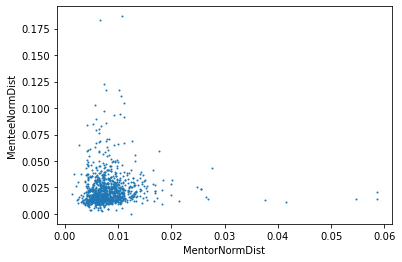

In [53]:
d2.plot.scatter(x='MentorNormDist',y='MenteeNormDist',s=1)

In [54]:
pearsonr(d2['MentorNormDist'],d2['MenteeNormDist'])

(0.012646464048279193, 0.6895748477361936)

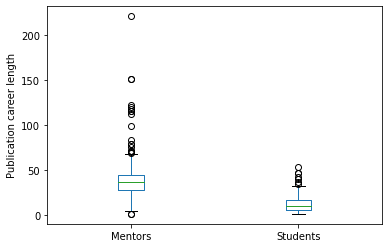

In [57]:
#_, p = ttest_rel(m_sample['MentorNPubYears'],m_sample['MenteeNPubYears'])
ax = m_sample.boxplot(['MentorNPubYears','MenteeNPubYears'])
ax.set_ylabel('Publication career length')
ax.set_xticklabels(['Mentors','Students'])
ax.grid(False)

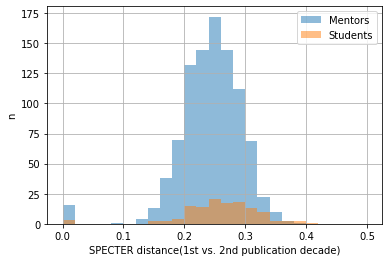

In [58]:
#calculate SPECTER distance between first two decades of career

# pub_career_lengths = pd.read_csv('pub_career_lengths.csv')
# twenty_years = pub_career_lengths.loc[pub_career_lengths['NPubYears']>=20,'PID'].unique()

# d = []
# for i,pid in enumerate(twenty_years):
#     ps = author_pub_space(pid)
#     y = int(ps['Year'].min())
#     dist = pub_space_distance(pid, pid, y1=[y,y+10], y2=[y+10,y+20])
#     d.append((pid,dist))
#     print(f'\r{pid} ({i+1}/{len(twenty_years)})',end='')
# d = pd.DataFrame().from_records(d,columns=['PID','TwoDecadeSpecter'])
#
# specter_dists = specter_dists.merge(d, on='PID', how='outer')
# specter_dists.to_csv('specter_dists.csv', index=False)

d1 = specter_dists[['PID','TwoDecadeSpecter']].rename({'PID':'MentorID','TwoDecadeSpecter':'MentorTwoDecadeSpecter'},axis=1)
m_sample = m_sample.merge(d1)
d2 = specter_dists[['PID','TwoDecadeSpecter']].rename({'PID':'MenteeID','TwoDecadeSpecter':'MenteeTwoDecadeSpecter'},axis=1)
m_sample = m_sample.merge(d2)

m_sample['MentorTwoDecadeSpecter'].hist(alpha=0.5, label='Mentors', range=[0,0.5], bins=25)
m_sample['MenteeTwoDecadeSpecter'].hist(alpha=0.5, label='Students', range=[0,0.5], bins=25)
plt.xlabel('SPECTER distance(1st vs. 2nd publication decade)')
plt.ylabel('n')
plt.legend();

In [307]:
#save specter dist data in a compact format
# d = pd.merge(specter_dists,pub_career_lengths)
# d['MinMaxYearSpecterNorm'] = d['MinMaxYearSpecter']/d['NPubYears']
# d['IsMentee'] = d['PID'].isin(m_sample['MenteeID'])
# d['IsMentor'] = d['PID'].isin(m_sample['MentorID'])
# d = d.merge(m_sample.loc[:,['MenteeID','StopYear']], left_on='PID', right_on='MenteeID', how='outer')
# d = d.drop(columns='MenteeID')
# d = d.merge(m_sample.loc[:,['MentorID','MentorStopYear']], left_on='PID', right_on='MentorID', how='outer')
# d = d.drop(columns='MentorID')

# d.to_csv('specter_dists_career_lengths.csv', index=False)

In [ ]:
#save specter distances between each year's publications and the next for each researcher
# d = []

# for i,pid in enumerate(pids_sample):
#     ps = author_pub_space(pid)
#     ymin = int(ps['Year'].min())
#     ymax = int(ps['Year'].max())
#     for j,y in enumerate(range(ymin+1,ymax)):
#         dist = pub_space_distance(pid, pid, y1=[y-1,y], y2=[y,y+1])
#         d.append((pid,y,dist))
#         print(f'\r{pid} {y} ({i+1}/{len(pids_sample)})',end='')

# d = pd.DataFrame().from_records(d,columns=['PID','Year','Dist'])
# d.to_csv('specter_dists_by_year.csv',index=False)

Text(0.5, 1.0, 'pid: 437950')

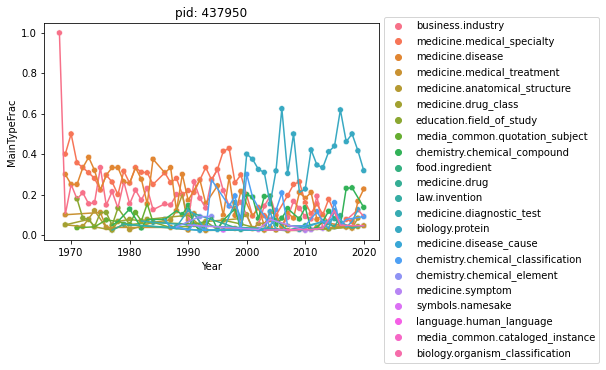

In [23]:
#can we label topic switches by the type of keywords that change?

#identify researchers that with long careers and high specter distance
#d.loc[d['NPubYears']>10].sort_values(by='MinMaxYearSpecter',ascending=False)[:50]['PID'].values

#plot a few examples
pid = 437950
# pid = 107884
# pid = 182602
ks = author_kw_space(pid).groupby('Year')['MainType'].value_counts(normalize=True).rename('MainTypeFrac').reset_index()
ax = scatterplot(data=ks, hue='MainType', x='Year', y='MainTypeFrac')
ax.legend(bbox_to_anchor=(1,1.05))
lineplot(data=ks, hue='MainType', x='Year', y='MainTypeFrac', ax=ax, legend=False)
ax.set_title(f'pid: {pid}')

In [302]:
#save specter distances between each year's publications and the next for each researcher
# d = []

# for i,pid in enumerate(pids_sample):
#     ps = author_pub_space(pid)
#     ymin = int(ps['Year'].min())
#     ymax = int(ps['Year'].max())
#     for j,y in enumerate(range(ymin+1,ymax)):
#         dist = pub_space_distance(pid, pid, y1=[y-1,y], y2=[y,y+1])
#         d.append((pid,y,dist))
#         print(f'\r{pid} {y} ({i+1}/{len(pids_sample)})',end='')

# d = pd.DataFrame().from_records(d,columns=['PID','Year','Dist'])
# d.to_csv('specter_dists_by_year.csv',index=False)

Text(0, 0.5, 'n')

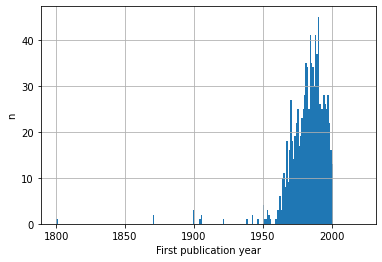

In [22]:
#distribution of first publication dates for mentors with at least 20 years of publication history
d = specter_dists_career_lengths.loc[(specter_dists_career_lengths['NPubYears']>20)]
ax = d.loc[(d['IsMentor']==True), 'MinPubYear'].hist(range=[1800,2021],bins=221)
ax.set_xlabel('First publication year')
ax.set_ylabel('n')

In [245]:
#FieldofStudy with greatest prevalence for each author x 10Years x FieldofStudy level, include prevalence

# d = []
# twenty_years = specter_dists_career_lengths.loc[(specter_dists_career_lengths['NPubYears']>=20),'PID'].unique()

# for i,pid in enumerate(twenty_years):
#     ks = author_kw_space(pid)
#     ymin = ks['Year'].min()
#     ks['Decade'] = np.nan
#     ks.loc[(ks['Year']<(ymin+10)), 'Decade'] = 1
#     ks.loc[(ks['Year']>=(ymin+10)) & (ks['Year']<(ymin+20)), 'Decade'] = 2
#     ks = ks.dropna(subset=['Decade'])
#     ks_frac = ks.groupby(['Decade','Level'])['FieldOfStudyId'].value_counts(normalize=True).rename('FieldOfStudyFrac').reset_index()
#     ks_frac = ks_frac.iloc[ks_frac.groupby(['Decade','Level'])['FieldOfStudyFrac'].idxmax()]
#     ks_frac = ks_frac.merge(kws[['FieldOfStudyId','NormalizedName']], how='inner')
#     ks_frac['PID'] = pid
#     d.append(ks_frac)
#     print(f'\r{pid} ({i+1}/{len(twenty_years)})',end='')
    
# d = pd.concat(d)

# d.to_csv('kws_decade_greatest_freq.csv', index=False)

In [244]:
#FieldofStudy with greatest change in prevalence for author Mentor x 10Years x FieldofStudy level
# d = []
# twenty_years = specter_dists_career_lengths.loc[(specter_dists_career_lengths['NPubYears']>=20),'PID'].unique()

# for i,pid in enumerate(twenty_years):
#     ks = author_kw_space(pid)
#     ymin = ks['Year'].min()
#     ks['Decade'] = np.nan
#     ks.loc[(ks['Year']<(ymin+10)), 'Decade'] = 1
#     ks.loc[(ks['Year']>=(ymin+10)) & (ks['Year']<(ymin+20)), 'Decade'] = 2
#     ks = ks.dropna(subset=['Decade'])
#     ks_frac = ks.groupby(['Decade','Level'])['FieldOfStudyId'].value_counts(normalize=True).rename('FieldOfStudyFrac').reset_index()
#     ks_frac = ks_frac.pivot(['Level','FieldOfStudyId'], 'Decade', 'FieldOfStudyFrac').fillna(0)
#     ks_frac['ChangeFrac'] = ks_frac.apply(np.max,axis=1) - ks_frac.apply(np.min,axis=1)
#     ks_frac = ks_frac.reset_index().loc[:,['Level','FieldOfStudyId','ChangeFrac']]
#     ks_frac = ks_frac.iloc[ks_frac.groupby('Level')['ChangeFrac'].idxmax()]
#     ks_frac = ks_frac.merge(kws[['FieldOfStudyId','NormalizedName']], how='inner')
#     ks_frac['PID'] = pid
#     d.append(ks_frac)
#     print(f'\r{pid} ({i+1}/{len(twenty_years)})',end='')
    
# d = pd.concat(d)
# d.to_csv('kws_decade_greatest_change.csv', index=False)

In [ ]:
#below here probably no longer relevant to project??

In [26]:
#calculate lab size for each mentor/year
#TODO: change to use years before graduation date instead of self-reported data

dy = []

for mentor_stop_year in range(1995,2005):
    #get mentor cohort
    mentor_ids = m.loc[m['MentorStopYear']==mentor_stop_year,'MentorID'].unique()

    for mentor_id in mentor_ids:
        
        d = m.loc[(m['MentorID']==mentor_id)&\
                  (m['StartYear']>0)&\
                  (m['StopYear']>0)&\
                  (m['StartYear']>mentor_stop_year)&\
                  (m['StopYear']<2021)&\
                  (m['PQadded']==1)]
        #for each mentor, count number of mentees in the lab in each year
        if d.shape[0] > 0:
            y1 = int(min(d['StartYear'].values))
            y2 = int(max(d['StopYear'].values))
            for i,y in enumerate(range(y1,y2+1)):
                mentee_ids = d.loc[(d['StartYear']<y) & (y<=d['StopYear']), 'MenteeID'].values
                continued = d.loc[(d['StartYear']<y) & (y<=d['StopYear']), 'Continued'].values
                dy.append({'MentorID':mentor_id,\
                           'MentorStopYear':mentor_stop_year,\
                           'Year':y,\
                           'YearIdx':i,\
                           'MenteeIDs':mentee_ids,\
                           'LabSize':len(mentee_ids),\
                           'Continued':continued,\
                           'NContinued':sum(continued)})
    
dy = pd.DataFrame(dy)

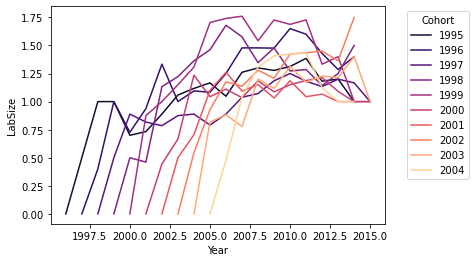

In [27]:
#plot mean lab size over time for each mentor cohort
mean_lab_size = dy.groupby(['MentorStopYear','Year'])['LabSize'].mean().reset_index()
palette = color_palette('magma', 10)
lineplot(data=mean_lab_size, x='Year', y='LabSize', hue='MentorStopYear', palette=palette)
plt.legend(title='Cohort', bbox_to_anchor=(1.05,1))

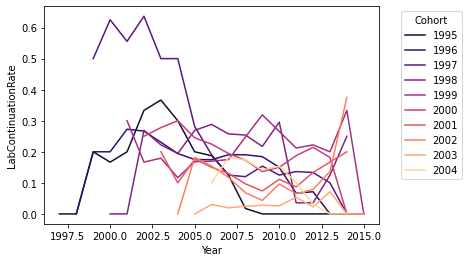

In [28]:
#plot mean continuation rate for each mentor cohort over time
dy['LabContinuationRate'] = dy['NContinued']/dy['LabSize']
mean_continuation_rate = dy.groupby(['MentorStopYear','Year'])['LabContinuationRate'].mean().reset_index()
lineplot(data=mean_continuation_rate, x='Year', y='LabContinuationRate', hue='MentorStopYear', palette=palette)
plt.legend(title='Cohort', bbox_to_anchor=(1.05,1))

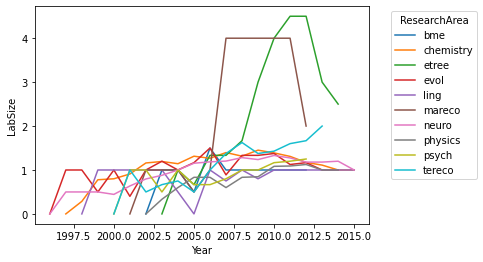

In [29]:
#plot mean lab size over time for the 5 largest research areas
dy = pd.merge(dy, m[['MentorID','ResearchArea']].drop_duplicates(), on='MentorID', how='left')
big_ra = dy.groupby('ResearchArea')['MentorID'].count().sort_values(ascending=False)[:10].index
mean_lab_size = dy.loc[dy['ResearchArea'].isin(big_ra)].groupby(['ResearchArea','Year'])['LabSize'].mean().reset_index()
ax = lineplot(data=mean_lab_size, x='Year', y='LabSize', hue='ResearchArea')
plt.legend(title='ResearchArea', bbox_to_anchor=(1.05,1))